In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 10))

import numpy as np
from numpy import cos, sin, pi
import scipy.interpolate as intp
import pandas as pd
from pathlib import Path

In [2]:
dataloc = Path('../data')

# Positions

Creates the `positions.txt` table from the `Job1.gt7` input. The output is the base of the site coordinate system.

## `xcoord()`, `ycoord()`, `zcoord()`

Convert from spherical to cartesian coordinates

$$
\begin{align}
x & = r\,\cos\varphi\,\sin\vartheta \\
y & = r\,\sin\varphi\,\sin\vartheta \\
z & = r\,\cos\vartheta
\end{align}
$$

The total station saves the prolar angles $\phi$ clockwise in degrees, minutes, seconds.
For the classic formula above we have $\varphi = -\phi\,\pi / 180$.

In [3]:
def xcoord(r, θ, ϕ):
    return r * cos(-ϕ * np.pi / 180.) * sin(θ * np.pi / 180.)

def ycoord(r, θ, ϕ):
    return r * sin(-ϕ * np.pi / 180.) * sin(θ * np.pi / 180.)

def zcoord(r, θ):
    return r * cos(θ * np.pi / 180.)

## Topcon `.gt7` file

- Read the file

In [4]:
with open(dataloc/'UB/JOB1.gt7', mode='r') as h:
    lines = h.readlines()

- Parse file line by line into an intermediate dictionary

In [5]:
d, pn = {}, -1
sstypes = [int, float, int]
sdtypes = [float, float, float]
for line in lines:
    idx = line.find(' ')
    k, v = line[:idx], line[idx:-1].strip()
    if k == 'SS':
        pn = int(v[:v.find(',')])
        v = [sstypes[i](val) for i, val in enumerate(v.split(','))]
    elif k == 'SD':
        v = [sdtypes[i](val) for i, val in enumerate(v.split(','))]
    if k == 'SS' or k == 'SD':
        k += "%03d" % pn
    d[k] = v

- Create raw cartesian data

In [6]:
cols = [
    'label', 'h_off',
    'r', 'ϕ', 'θ',
    'x_raw', 'y_raw', 'z_raw', 'x', 'y', 'z',
    'date', 'note'
]
coords = pd.DataFrame(columns=cols)

for k, v in d.items():
    if k.startswith('SS'):
        num = int(k[2:])
        coords.loc[num, 'h_off'] = v[1]
        coords.loc[num, 'note'] = 'n/a'
    elif k.startswith('SD'):
        num = int(k[2:])
        coords.loc[num, ['ϕ', 'θ', 'r']] = v
        coords.loc[num, ['x_raw', 'y_raw', 'z_raw']] = \
            xcoord(v[2], v[1], v[0]), \
            ycoord(v[2], v[1], v[0]), \
            zcoord(v[2], v[1])
coords = pd.DataFrame(coords, index=pd.Index(data=coords.index, name='point #'),
                      columns=cols)
coords = coords.loc[coords.loc[5:58].index.append(coords.loc[60:].index)]
coords.sort_index(inplace=True)
coords.head()

label h_off       r         ϕ        θ      x_raw      y_raw  \
point #                                                                
5         NaN   0.0  26.091  266.0937  87.4541  -1.775695  26.004692   
6         NaN   0.0   36.53   23.5036  91.5113  33.487636 -14.563341   
7         NaN   0.0  36.394   24.4506  91.5016  33.118754 -15.058614   
8         NaN   0.0  36.246   25.4001  91.4915  32.731171 -15.541973   
9         NaN   0.0  35.895   29.1611  91.4908   31.33481 -17.484525   

            z_raw    x    y    z date note  
point #                                     
5        1.158955  NaN  NaN  NaN  NaN  n/a  
6       -0.963446  NaN  NaN  NaN  NaN  n/a  
7         -0.9537  NaN  NaN  NaN  NaN  n/a  
8       -0.943434  NaN  NaN  NaN  NaN  n/a  
9        -0.93386  NaN  NaN  NaN  NaN  n/a

Height of the theodolites head and target staff were the same

In [7]:
htt = 1.605
lstaff = htt

### Identification of points from hand notes, and transfer to the `coords` table

In [8]:
tcol = ['label', 'h_off']

# Reference point measurements
coords.loc[5, tcol] = 'ref1-1', 0.
coords.loc[60, tcol] = 'ref1-2', 0.
coords.loc[121, tcol] = 'ref2-2', 0.
coords.loc[80, tcol] = 'ref1-3', 0.
coords.loc[95, tcol] = 'ref1-4', 0.


# Charge hole pipes
coords.loc[[6, 7, 8], tcol] = [
    ['pad1, pipe%d' % i, h]
    for i, h in zip([1, 2, 3], lstaff + np.array([.31, .33, .32]))
]
coords.loc[[9, 10, 11], tcol] = [
    ['pad2, pipe%d' % i, h]
    for i, h in zip([1, 2, 3], lstaff + np.array([.33, .30, .30]))
]
coords.loc[[13, 14, 15], tcol] = [
    ['pad3, pipe%d' % i, h]
    for i, h in zip([1, 2, 3], lstaff + np.array([.32, .31, .33]))
]
coords.loc[[16, 17, 18], tcol] = [
    ['pad4, pipe%d' % i, h]
    for i, h in zip([1, 2, 3], lstaff + np.array([.50, .52, .30]))
]
coords.loc[12, tcol] = 'pad2, pipe1a', lstaff + .33

# Buried balls
coords.loc[[19, 20], tcol] = [['pad1, balls%d' % i, lstaff] for i in [1, 2]]
coords.loc[[21, 22], tcol] = [['pad2, balls%d' % i, lstaff] for i in [1, 2]]
coords.loc[[23, 24], tcol] = [['pad3, balls%d' % i, lstaff] for i in [1, 2]]
coords.loc[[25, 26], tcol] = [['pad4, balls%d' % i, lstaff] for i in [1, 2]]

# Ejecta box branches
coords.loc[[27, 28], tcol] = [['pad1, ej.br.1-%d' % i, lstaff] for i in [1, 2]]
coords.loc[[29, 30], tcol] = [['pad1, ej.br.2-%d' % i, lstaff] for i in [1, 2]]
coords.loc[[31, 32], tcol] = [['pad2, ej.br.1-%d' % i, lstaff] for i in [1, 2]]
coords.loc[[33, 34], tcol] = [['pad2, ej.br.2-%d' % i, lstaff] for i in [1, 2]]
coords.loc[[35, 36], tcol] = [['pad3, ej.br.1-%d' % i, lstaff] for i in [1, 2]]
coords.loc[[37, 38], tcol] = [['pad3, ej.br.2-%d' % i, lstaff] for i in [1, 2]]
coords.loc[[39, 40], tcol] = [['pad4, ej.br.1-%d' % i, lstaff] for i in [1, 2]]
coords.loc[[41, 42], tcol] = [['pad4, ej.br.2-%d' % i, lstaff] for i in [1, 2]]

# Electrostatic field sensors
coords.loc[[43, 44], tcol] = [['EL1', lstaff], ['EL2', lstaff]]

# Microphones
coords.loc[45:48, tcol] = [
    ['mic %dº' % ang, lstaff]
    for ang in [90, 120, 150, 180]
]
coords.loc[49:51, tcol] = [['mic %dº' % ang, lstaff] for ang in [60, 30, 0]]
# Ground impedance
coords.loc[[53, 54, 55, 56, 58], tcol] = [
    ['gi%d' % i, lstaff]
    for i in range(1, 6)
]
# Other for BYU
coords.loc[52, tcol] = ['byu-?', lstaff]
coords.loc[57, tcol] = ['80m', lstaff]
coords.loc[58, tcol] = ['daq', lstaff]

# Pad blocks
coords.loc[61:64, tcol] = [['pad1, block%d' % i, lstaff] for i in [1, 2, 3, 4]]
coords.loc[81:84, tcol] = [['pad2, block%d' % i, lstaff] for i in [1, 2, 3, 4]]
coords.loc[98:101, tcol] = [['pad3, block%d' % i, lstaff] for i in [1, 2, 3, 4]]
coords.loc[109:112, tcol] = [
    ['pad4, block%d' % i, lstaff]
    for i in [1, 2, 3, 4]
]

# 4k-ring
coords.loc[65:67, tcol] = [
    ['4k%d' % i, l]
    for i, l in zip([6, 5, 4], 3 * [lstaff])
]
coords.loc[68:70, tcol] = [['4k%d' % i, l] for i, l in zip([3, 2, 1], 3 * [0.])]

# FLIRs
coords.loc[71:72, tcol] = [['FLIR%d' % i, lstaff] for i in [1, 2]]
coords.loc[73, tcol] = 'Kestrel', lstaff

# tree & tree camera
coords.loc[74, tcol] = 'tree', lstaff
coords.loc[108, tcol] = 'tree-cam', 0.

# roof cams
# pad 1
coords.loc[75, tcol] = 'UB-c1-pad1', 0.
coords.loc[76, tcol] = 'UB-c2-pad1', 0.
coords.loc[77, tcol] = 'INGV-NAC-pad1', 0.
coords.loc[78, tcol] = 'INGV-cam#2-pad1', 0.
# pad 2
coords.loc[91, tcol] = 'UB-c1-pad2', 0.
coords.loc[92, tcol] = 'UB-c2-pad2', 0.
coords.loc[93, tcol] = 'INGV-NAC-pad2', 0.
coords.loc[94, tcol] = 'INGV-cam#2-pad2', 0.
# pad 3
coords.loc[96, tcol] = 'UB-c1-pad2a', 0.
coords.loc[97, tcol] = 'UB-c2-pad2a', 0.

# ping-pong balls
coords.loc[85:90, tcol] = [['pp-pad2, %d' % i, lstaff] for i in range(1, 7)]
coords.loc[102:107, tcol] = [['pp-pad3, %d' % i, lstaff] for i in range(1, 7)]
coords.loc[113:119, tcol] = [['pp-pad4, %d' % i, lstaff] for i in range(1, 8)]
coords.loc[120, tcol] = 'pp-pad4, ?', lstaff

# unknown
coords.loc[79, tcol] = 'unknown', np.nan

- Sort table by point\#

In [9]:
coords.sort_index(inplace=True)

- Assign dates

In [10]:
coords.loc[:58, 'date'] = '2018-07-25'
coords.loc[60:, 'date'] = '2018-07-26'

In [11]:
coords.head()

label  h_off       r         ϕ        θ      x_raw      y_raw  \
point #                                                                        
5             ref1-1    0.0  26.091  266.0937  87.4541  -1.775695  26.004692   
6        pad1, pipe1  1.915   36.53   23.5036  91.5113  33.487636 -14.563341   
7        pad1, pipe2  1.935  36.394   24.4506  91.5016  33.118754 -15.058614   
8        pad1, pipe3  1.925  36.246   25.4001  91.4915  32.731171 -15.541973   
9        pad2, pipe1  1.935  35.895   29.1611  91.4908   31.33481 -17.484525   

            z_raw    x    y    z        date note  
point #                                            
5        1.158955  NaN  NaN  NaN  2018-07-25  n/a  
6       -0.963446  NaN  NaN  NaN  2018-07-25  n/a  
7         -0.9537  NaN  NaN  NaN  2018-07-25  n/a  
8       -0.943434  NaN  NaN  NaN  2018-07-25  n/a  
9        -0.93386  NaN  NaN  NaN  2018-07-25  n/a

## Fine adjustments

Measurement of blast pipes was done at top of pipes. Therefore the leveling bubble of the target staff could not be watched. Here we adjust the triangular pads to equal distances of 60 cm. Local measurements showed that the blast pipe locations were within +- 1 cm

In [12]:
coords.loc[12:20]

label  h_off       r        ϕ        θ      x_raw      y_raw  \
point #                                                                        
12       pad2, pipe1a  1.935   34.71  35.3223  91.5605  28.309824 -20.061019   
13        pad3, pipe1  1.925  34.705    35.29  91.5604   28.31705  -20.04217   
14        pad3, pipe2  1.915  35.224  35.5941  91.5616  28.632135 -20.494136   
15        pad3, pipe3  1.935  34.718  36.3128  91.5425  27.965488 -20.552314   
16        pad4, pipe1  2.105  34.649  40.4714  91.2832  26.351925 -22.483931   
17        pad4, pipe2  2.125  35.165  41.1541  91.2438  26.470979 -23.136159   
18        pad4, pipe3  1.905  34.703  41.4505  91.5746  26.001045 -22.963766   
19       pad1, balls1  1.605  36.593  23.1328   92.244  33.624998 -14.365034   
20       pad1, balls2  1.605   36.21  26.1412  92.2418  32.481236 -15.941366   

            z_raw    x    y    z        date note  
point #                                            
12       -0.94524  NaN  NaN  NaN  2018-07-25  n/a  
13      -0.945043  NaN  NaN  NaN  2018-07-25  n/a  
14      -0.959913  NaN  NaN  NaN  2018-07-25  n/a  
15      -0.934555  NaN  NaN  NaN  2018-07-25  n/a  
16      -0.775936  NaN  NaN  NaN  2018-07-25  n/a  
17      -0.763316  NaN  NaN  NaN  2018-07-25  n/a  
18      -0.953586  NaN  NaN  NaN  2018-07-25  n/a  
19      -1.432805  NaN  NaN  NaN  2018-07-25  n/a  
20       -1.41642  NaN  NaN  NaN  2018-07-25  n/a

In [13]:
coords.loc[14, ['x_raw', 'y_raw']] = 28.580, -20.574

In [14]:
coords.loc[17, ['x_raw', 'y_raw']] = 26.598, -23.029

## Plot raw coordinates

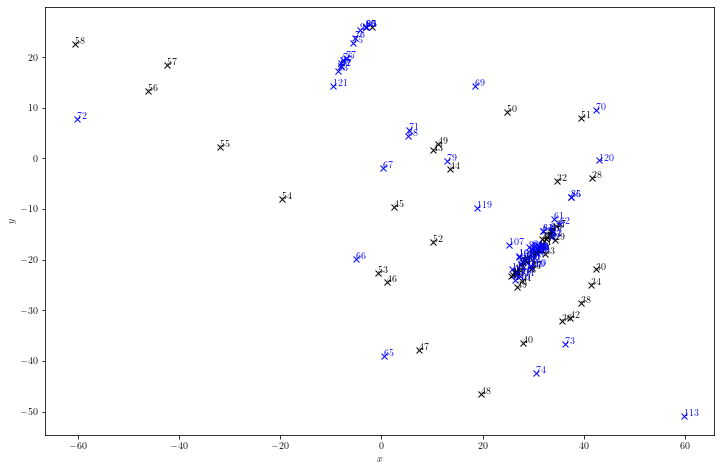

In [15]:
fig, ax = plt.subplots()

ax.set_aspect(1.0)
ax.plot(coords.x_raw.loc[:59].values, coords.y_raw.loc[:59].values, 'xk')
ax.plot(coords.x_raw.loc[60:].values, coords.y_raw.loc[60:].values, 'xb')
for loc in coords.loc[:59].index:
    ax.annotate(str(loc), xy=coords.loc[loc, ['x_raw', 'y_raw']].values)
for loc in coords.loc[60:].index:
    ax.annotate(str(loc), xy=coords.loc[loc, ['x_raw', 'y_raw']].values, color='b')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

# fig

## Rotate parallel to Building 

Rotation in a 2D cartesian coordinate system

$$
\pmb{x} = R\,\tilde{\pmb{x}}
\quad,\quad
R = 
\begin{pmatrix}
\cos\phi_0 & -\sin\phi_0 \\
\sin\phi_0 & \cos\phi_0
\end{pmatrix}
$$

The tilde vector $\tilde{\pmb{x}}$ is made from the coordinates of the raw data
(`x_raw`, `y_raw`).

Find a polar angle $\phi_0$, so that the vector ${\pmb{b}}_{21}$, that connects the two base points coincides with the $x$-axis of the new coordinate system, i.e. $\pmb{b}_{21} = r_{21}\,\pmb{e}_x$, the $y$-component in the new coordinate system vanishes. Therefore:

$$
[\pmb{b}_{21}]_y = 0 = \tilde{x}\sin\phi_0 + \tilde{y}\cos\phi_0
$$

and

$$
\phi_0 = -\arctan(\tilde{y}\,/\tilde{x})
$$

In [16]:
rawsel = ['x_raw', 'y_raw']

In [17]:
coords.loc[coords.label.str.contains('ref')]

label h_off       r         ϕ        θ     x_raw      y_raw  \
point #                                                                 
5        ref1-1   0.0  26.091  266.0937  87.4541 -1.775695  26.004692   
60       ref1-2   0.0   26.08   263.325  87.4401 -3.028446  25.877366   
80       ref1-3   0.0  26.079  263.2653  87.4408 -3.055292  25.873219   
95       ref1-4   0.0  26.087   263.281  87.4347 -3.049122  25.881869   
121      ref2-2   0.0  17.221  236.0218  86.3448  -9.60485  14.251469   

            z_raw    x    y    z        date note  
point #                                            
5        1.158955  NaN  NaN  NaN  2018-07-25  n/a  
60       1.164832  NaN  NaN  NaN  2018-07-26  n/a  
80       1.164469  NaN  NaN  NaN  2018-07-26  n/a  
95       1.167601  NaN  NaN  NaN  2018-07-26  n/a  
121      1.097873  NaN  NaN  NaN  2018-07-26  n/a

The second refenence point for the first day got lost somewhere in the depths of the top con configuration menu. But it can be reconstructed with the data of the next day measurement (point \#121). This measurement was done in the new day's coordinate system. The difference between the two systems is the vector of two measurements of the same physical point, for example ref1

In [18]:
strans = coords.loc[5, rawsel] - coords.loc[60, rawsel]
strans

x_raw    1.252751
y_raw    0.127326
dtype: object

In [19]:
coords.loc[60, rawsel]

x_raw    -3.028446
y_raw    25.877366
Name: 60, dtype: object

In [20]:
coords.loc[5, rawsel] - strans

x_raw    -3.028446
y_raw    25.877366
dtype: object

- Reference point 2 in the first day's coordinate system is

In [21]:
ref1x, ref1y = coords.loc[5, rawsel]
ref1px, ref1py = coords.loc[60, rawsel]
stransx, stransy = strans

In [22]:
ϕ1 = np.arctan(
    (
        coords.loc[5, 'x_raw'] * coords.loc[60, 'y_raw']
        - coords.loc[5, 'y_raw'] * coords.loc[60, 'x_raw']
    ) / 
    (
        np.sqrt((coords.loc[5, rawsel] ** 2).sum())
        * np.sqrt((coords.loc[60, rawsel] ** 2).sum())
    )
)

180 * ϕ1 / pi

2.7654730456688847

In [23]:
ϕ1 = (  coords.loc[5, 'x_raw'] * coords.loc[60, 'y_raw']
      - coords.loc[5, 'y_raw'] * coords.loc[60, 'x_raw']) \
    / (  np.sqrt((coords.loc[5, rawsel] ** 2).sum())
       * np.sqrt((coords.loc[60, rawsel] ** 2).sum()))

180 * ϕ1 / pi

2.767622591293879

In [24]:
b21 = coords.loc[121, rawsel] - coords.loc[60, rawsel]
b21

x_raw    -6.576404
y_raw   -11.625897
dtype: object

In [25]:
xt, yt = b21
ϕ0 = np.arctan(yt / xt) + np.pi
ϕ0 * 180 / pi

240.50452374967747

- define $z = 0$ as elevation of ground at total station location

In [26]:
coords['z'] = coords['z_raw'] + htt - coords['h_off']

- Move origin of horizontal coordinates to building corner of the reference point,
  and rotate by $\phi_0$

In [27]:
rot0 = np.array([[cos(ϕ0), sin(ϕ0)],
                 [-sin(ϕ0), cos(ϕ0)]])
rot1 = np.array([[cos(ϕ1), -sin(ϕ1)],
                 [sin(ϕ1), cos(ϕ1)]])

base1 = coords.loc[5, rawsel].copy()
base2 = coords.loc[60, rawsel]

for row in coords.loc[:59].index:
    sel = coords.loc[row, rawsel]
    coords.loc[row, ['x', 'y']] = np.dot(rot0, np.dot(rot1, sel - base1))

for row in coords.loc[60:].index:
    coords.loc[row, ['x', 'y']] = np.dot(rot0, coords.loc[row, rawsel] - base2)

## Plot rotated coordinates

width of facilities building

In [28]:
bw = np.sqrt(np.sum(b21 ** 2))
bw

13.357042256906073

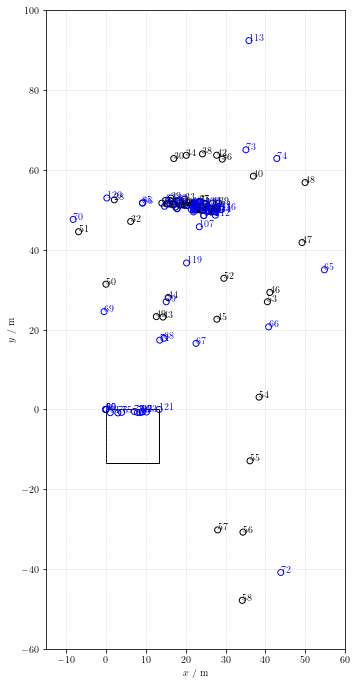

In [29]:
fig, ax = plt.subplots()

ax.set_aspect(1.0)
ax.scatter(coords.x.loc[:59], coords.y.loc[:59],
           marker='o', c='None', edgecolors='black')
ax.scatter(coords.x.loc[60:], coords.y.loc[60:],
           marker='o', c='None', edgecolors='blue')
for loc in coords.loc[:59].index:
    ax.annotate(str(loc), xy=coords.loc[loc, ['x', 'y']])
for loc in coords.loc[60:].index:
    ax.annotate(str(loc), xy=coords.loc[loc, ['x', 'y']], color='b')

rect = plt.Rectangle(coords.loc[5, ['x', 'y']] - np.array([0, bw]),
                     bw, bw, ec='black', fill=False)
ax.add_artist(rect)

ax.set_ylim(-60, 100)
ax.set_xlim(-15, 60)
ax.set_xlabel(r'$x\ /\ \mathrm{m}$')
ax.set_ylabel(r'$y\ /\ \mathrm{m}$')
ax.grid(ls='dotted', lw=.5)

fig.subplots_adjust(top=0.985, bottom=0.055, left=0.125, right=0.955)
fig.set_size_inches(5.03, 9.54)
# fig

In [30]:
coords.columns

Index(['label', 'h_off', 'r', 'ϕ', 'θ', 'x_raw', 'y_raw', 'z_raw', 'x', 'y',
       'z', 'date', 'note'],
      dtype='object')

In [31]:
coords.head()

label  h_off       r         ϕ        θ      x_raw      y_raw  \
point #                                                                        
5             ref1-1    0.0  26.091  266.0937  87.4541  -1.775695  26.004692   
6        pad1, pipe1  1.915   36.53   23.5036  91.5113  33.487636 -14.563341   
7        pad1, pipe2  1.935  36.394   24.4506  91.5016  33.118754 -15.058614   
8        pad1, pipe3  1.925  36.246   25.4001  91.4915  32.731171 -15.541973   
9        pad2, pipe1  1.935  35.895   29.1611  91.4908   31.33481 -17.484525   

            z_raw          x          y         z        date note  
point #                                                             
5        1.158955       -0.0        0.0  2.763955  2018-07-25  n/a  
6       -0.963446  15.480721  51.474412 -1.273446  2018-07-25  n/a  
7         -0.9537   16.09644  51.426863   -1.2837  2018-07-25  n/a  
8       -0.943434  16.712065  51.357142 -1.263434  2018-07-25  n/a  
9        -0.93386  19.100087  51.213321  -1.26386  2018-07-25  n/a

In [32]:
coords.tail()

label  h_off       r         ϕ        θ      x_raw      y_raw  \
point #                                                                       
117      pp-pad4, 5  1.605   34.66   37.0422   92.251  27.643988 -20.863179   
118      pp-pad4, 6  1.605  34.545   36.2312  92.2259  27.844304 -20.402244   
119      pp-pad4, 7  1.605  21.358   27.3425  93.4303  18.937824  -9.792336   
120      pp-pad4, ?  1.605  42.974    0.5852  92.3417  42.935874  -0.438548   
121          ref2-2    0.0  17.221  236.0218  86.3448   -9.60485  14.251469   

            z_raw          x          y         z        date note  
point #                                                             
117      -1.36135  25.580996  49.710054  -1.36135  2018-07-26  n/a  
118     -1.341711  25.081174  49.657464 -1.341711  2018-07-26  n/a  
119      -1.27794  20.231516  36.681473  -1.27794  2018-07-26  n/a  
120     -1.755875   0.274474  52.963862 -1.755875  2018-07-26  n/a  
121      1.097873  13.357042        0.0  2.702873  2018-07-26  n/a

## Output

### write data to csv file

In [34]:
h = open(dataloc / 'UB/positions.txt', mode='w')

sep = "\t"
lines = [sep.join(["point"] + list(coords.columns[:-2])) + '\n']
for row in coords.index:
    rw = coords.loc[row]
    rs = str(row) + sep
    rs += '"%s"%s%.3f%s%.3f%s%.4f%s%.4f%s%.3f%s%.3f%s%.3f%s%.3f%s%.3f%s%.3f\n' % (
        rw.label, sep, rw.h_off, sep,
        rw.r, sep, rw['ϕ'], sep, rw['θ'], sep,
        rw.x_raw, sep, rw.y_raw, sep, rw.z_raw, sep,
        rw.x, sep, rw.y, sep, rw.z
    )
    lines.append(rs)
h.writelines(lines)
h.close()

### TeX table 1

In [35]:
s = r"""
\begin{longtable}{
  r
  l
  S[table-figures-integer=2, table-figures-decimal=3]
  S[table-figures-integer=2, table-figures-decimal=3]
  S[table-figures-integer=2, table-figures-decimal=3]}
\caption{Positions in common coordinate system.} \\
\toprule
point \# & label & $x$ & $y$ & $z$ \\
 &  & m & m & m \\
\midrule
\endhead"""

for row in coords.index:
    sel = coords.loc[row]
    rs = "\n%s & %s & %.3f & %.3f & %.3f \\\\" \
        % tuple([sel.name] + list(sel[['label', 'x', 'y', 'z']]))
    rs = rs.replace("#", r"\#")
    rs = rs.replace("º", r"\textdegree")
    rs = rs.replace("nan", "{--}")
    s += rs

s += r"""
\bottomrule
\end{longtable}
"""

### TeX table 2

In [37]:
s = r"""
\begin{longtable}{
  @{}r
  S[table-figures-integer=1, table-figures-decimal=3]
  S[table-figures-integer=2, table-figures-decimal=3]
  S[table-figures-integer=3, table-figures-decimal=4]
  S[table-figures-integer=2, table-figures-decimal=4]
  S[table-figures-integer=2, table-figures-decimal=3]
  S[table-figures-integer=2, table-figures-decimal=3]
  S[table-figures-integer=2, table-figures-decimal=3]
  l}
\caption{Raw data.} \\
\toprule
{point \#} & {$h_{\text{off}}$} & {$r$} & {$\phi$} & {$\theta$} & {$x_{\text{raw}}$} & {$y_{\text{raw}}$} & {$z_{\text{raw}}$} \\
{} & {m} & {m} & {\textdegree} & {\textdegree} & {m} & {m} & {m} \\
\midrule
\endhead"""

for row in coords.index:
    sel = coords.loc[row]
    rs = "\n%s & %.3f & %.3f & %.4f & %.4f & %.3f & %.3f & %.3f \\\\" % tuple([sel.name] + list(sel[['h_off', 'r', 'ϕ', 'θ', 'x_raw', 'y_raw', 'z_raw']]))
    rs = rs.replace("#", r"\#")
    rs = rs.replace("º", r"\textdegree")
    rs = rs.replace("nan", "{--}")
    s += rs

s += r"""
\bottomrule
\end{longtable}
"""